0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


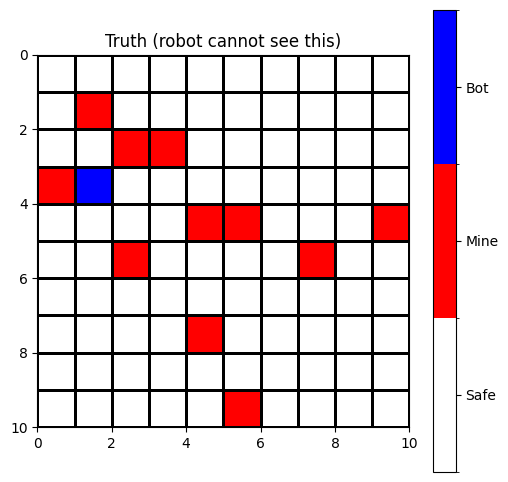

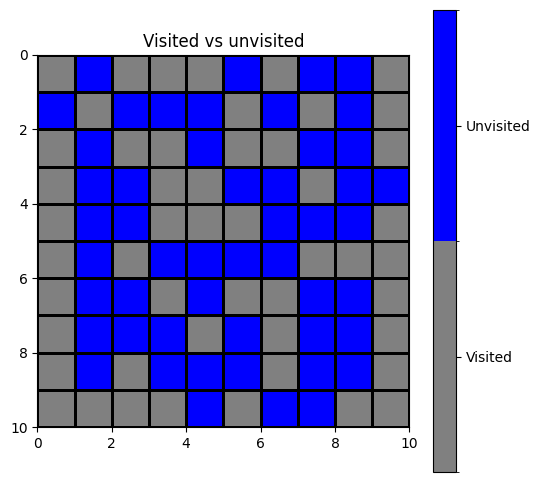

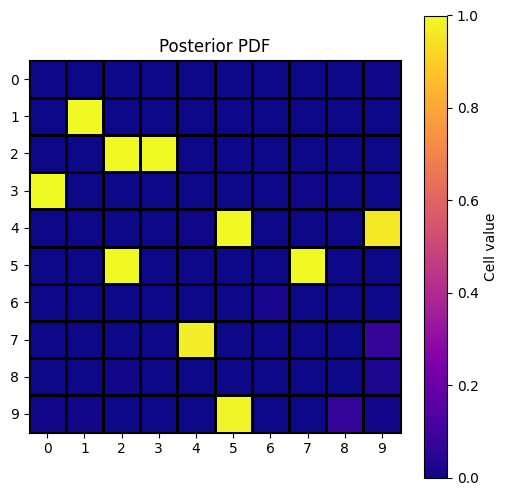

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors


########### GLOBALS and fn definitions

WIDTH = 10
HEIGHT = 10

p_g_m = 0.95 # p detecting (p for +) a mine given there's actually is a mine
n_g_m = 0.05 # p detecting no mine (n for -) given there's actually is a mine


p_g_nm = 0.3 # p detecting a mine given there's actually not a mine
n_g_nm = 0.7 # p detecting no mine given there's actually not a mine


PRIOR_MINE = 0.1
PRIOR_NO_MINE = 1-PRIOR_MINE

GAME_GRID = np.zeros((HEIGHT,WIDTH))
posterior_grid = np.zeros((HEIGHT,WIDTH))
posterior_grid.fill(PRIOR_MINE)
PROBE_GRID = np.zeros((HEIGHT,WIDTH))
PROBE_GRID.fill(-1) # we don't know anything yet
VISIT_GRID = np.zeros((HEIGHT,WIDTH))

POS_COUNT = np.zeros((HEIGHT, WIDTH), dtype=int)  # num + readings at cell
NEG_COUNT = np.zeros((HEIGHT, WIDTH), dtype=int)  # num - readings at cell

BOT_ROW = None
BOT_COL = None

######## set up the board

# randomly fill the grid
for row in np.arange(HEIGHT):
    for col in np.arange(WIDTH):
        GAME_GRID[row,col] = np.random.choice([0,1],p=[PRIOR_NO_MINE,PRIOR_MINE])

# place the bot randomly but not on a mine:
unplaced = True
while unplaced == True:
    row = np.random.randint(0,10)
    col = np.random.randint(0,10)

    if GAME_GRID[row,col] != 1:
        GAME_GRID[row,col] = 2
        unplaced = False
        BOT_ROW = row
        BOT_COL = col

VISIT_GRID[BOT_ROW,BOT_COL] = 1 # we've been here already and haven't blown up
posterior_grid[BOT_ROW,BOT_COL] = 0


###### functions ############


def enum_dirs(bot_row, bot_col):
    # all 8 neighbour offsets
    moves = [(-1, 0), ( 1, 0),  # N, S
             ( 0,-1), ( 0, 1),  # W, E
             (-1,-1), (-1, 1),  # NW, NE
             ( 1,-1), ( 1, 1)]  # SW, SE

    dirs = []
    for dr, dc in moves:
        r, c = bot_row + dr, bot_col + dc
        if 0 <= r < HEIGHT and 0 <= c < WIDTH:
            dirs.append((r, c))
    return dirs

def noisy_measure(probe_loc):

    if VISIT_GRID[probe_loc] == 1: # there's no mine as we've been there:
        return 0

    if GAME_GRID[probe_loc] == 0: # there's no mine
        return np.random.choice([0,1],p=[n_g_nm,p_g_nm])

    if GAME_GRID[probe_loc] == 1: # there's a mine
        return np.random.choice([0,1],p=[n_g_m,p_g_m])

def probe_and_update(bot_row, bot_col):
    coords = enum_dirs(bot_row, bot_col)
    for (r, c) in coords:
        obs = noisy_measure((r, c))  # 0 or 1
        if obs == 1:
            POS_COUNT[r, c] += 1
        else:
            NEG_COUNT[r, c] += 1

        n_pos = POS_COUNT[r, c]
        n_trails = n_pos + NEG_COUNT[r, c]
        posterior_grid[r, c] = posterior_from_counts(PRIOR_MINE, n_pos, n_trails)

        PROBE_GRID[r, c] = obs

def posterior_from_counts(p0, k, n, a=p_g_m, b=p_g_nm):

    # logit(p0) + k*log(a/b) + (n-k)*log((1-a)/(1-b))
    logit = np.log(max(p0,1e-12) / max(1-p0,1e-12))
    log_lr_pos = np.log(a / b)
    log_lr_neg = np.log((1 - a) / (1 - b))
    logit_post = logit + k*log_lr_pos + (n-k)*log_lr_neg
    p = 1 / (1 + np.exp(-logit_post))
    return float(np.clip(p, 1e-12, 1-1e-12))

def bin_ent(x):
    x = float(np.clip(x, 1e-12, 1-1e-12))
    return -(x*np.log2(x) + (1-x)*np.log2(1-x))

def IG_one_cell(p):
    q1 = p * p_g_m + (1 - p) * p_g_nm
    q0 = p * n_g_m + (1 - p) * n_g_nm
    p1_o1 = (p * p_g_m) / max(q1, 1e-12)
    p1_o0 = (p * n_g_m) / max(q0, 1e-12)
    return max(bin_ent(p) - (q1*bin_ent(p1_o1) + q0*bin_ent(p1_o0)), 0.0)


def IG_future_set(candidate_row, candidate_col, min_ig_bits=0.005):
    coords = enum_dirs(candidate_row, candidate_col)
    IG_total = 0.0
    for (r, c) in coords:
        p = float(posterior_grid[r, c])
        ig = IG_one_cell(p)
        if ig >= min_ig_bits:
            IG_total += ig
    return IG_total

def best_move_EFE(bot_r, bot_c, lam=2.0):
    best_move = None
    best_score = -1e18

    for direction in enum_dirs(bot_r, bot_c):

        (row, col) = direction
        risk = float(posterior_grid[row, col])         # stepping risk

        if risk > 0.3:
            continue

        IG = IG_future_set(row, col)    # info gain after moving there
        score = IG - lam * risk         # tune risk appetite via lam

        if score > best_score:
            best_score, best_move = score, (row, col)
    return best_move, best_score

#### PLOTTING #####




def plot_truth(game_grid):

    cmap = mcolors.ListedColormap(["white", "red", "blue"])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    x_edges = np.arange(game_grid.shape[1] + 1)
    y_edges = np.arange(game_grid.shape[0] + 1)

    plt.figure(figsize=(6, 6))
    plt.pcolormesh(x_edges, y_edges, game_grid, cmap=cmap, norm=norm,
                   edgecolors="k", linewidth=1)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect("equal")

    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels([ "Safe", "Mine", "Bot"])
    plt.title("Truth (robot cannot see this)")
    plt.show()

def plot_explored(game_grid):

    cmap = mcolors.ListedColormap(["grey", "blue"])
    bounds = [-0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    x_edges = np.arange(game_grid.shape[1] + 1)
    y_edges = np.arange(game_grid.shape[0] + 1)

    plt.figure(figsize=(6, 6))
    plt.pcolormesh(x_edges, y_edges, game_grid, cmap=cmap, norm=norm,
                   edgecolors="k", linewidth=1)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect("equal")

    cbar = plt.colorbar(ticks=[0, 1,])
    cbar.ax.set_yticklabels(["Visited", "Unvisited"])
    plt.title("Visited vs unvisited")
    plt.show()



def plot_pdf(grid):
# grid edges
    x_edges = np.arange(WIDTH + 1)
    y_edges = np.arange(HEIGHT + 1)

    plt.figure(figsize=(6,6))
    plt.pcolormesh(x_edges, y_edges, grid, cmap="plasma", edgecolors="k", linewidth=1)
    plt.gca().invert_yaxis()  # (0,0) at top-left

    # ticks in the middle of each square
    plt.xticks(np.arange(WIDTH) + 0.5, labels=np.arange(WIDTH))
    plt.yticks(np.arange(HEIGHT) + 0.5, labels=np.arange(HEIGHT))

    plt.gca().set_aspect("equal")  # squares stay square
    plt.colorbar(label="Cell value")
    plt.title("Posterior PDF")
    plt.show()

TURNS = 100
for turn in np.arange(TURNS):
    print(turn)

    probe_and_update(BOT_ROW, BOT_COL)

    # 2. Find the action with the minimum EFE
    dir,_= best_move_EFE(BOT_ROW, BOT_COL)

    # 3. take the action
    NEW_BOT_ROW = dir[0]
    NEW_BOT_COL = dir[1]

    # 4. check if we stepped on a mine and are dead
    if GAME_GRID[NEW_BOT_ROW,NEW_BOT_COL] == 1: # boom
        print("game over")
        break
    elif GAME_GRID[NEW_BOT_ROW,NEW_BOT_COL] == 0: # we're fine do book keeping

        posterior_grid[NEW_BOT_ROW,NEW_BOT_COL] = 0

        #new location
        GAME_GRID[NEW_BOT_ROW,NEW_BOT_COL] = 2

        # clear old location
        GAME_GRID[BOT_ROW,BOT_COL] = 0

        # mark off we've visited the new location
        VISIT_GRID[NEW_BOT_ROW,NEW_BOT_COL] = 1 # we've explored the new tile

        # update bot location
        BOT_ROW = NEW_BOT_ROW
        BOT_COL = NEW_BOT_COL
    else:
        print("uh oh")

plot_pdf(posterior_grid)

plot_truth(GAME_GRID)

plot_explored(VISIT_GRID)





